In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

breathDetection_v1.2

This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

New this version: 
- went back to calculating 30s average breath rate

- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

- plotting average of rise and fall breath rate as well (rfmav)

In [2]:
# read in dataset Jill
dset = pd.read_csv('Sherin Spofford 04-29-2016.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))

In [3]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/20) # add timestamp assuming 20 samples / second
print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp) 

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

   chest  belly  ax  ay  az  gx  gy  gz  time
0   2773   2433  52 -10  33 -24   2  12  0.00
1   2782   2564  52 -10  33 -23  19  18  0.05
2   2792   2468  52 -10  33 -17  17  14  0.10
3   2790   2581  52 -10  33 -14  20  13  0.15
4   2795   2597  45  -9  51  -8  21  14  0.20


In [4]:
f = d

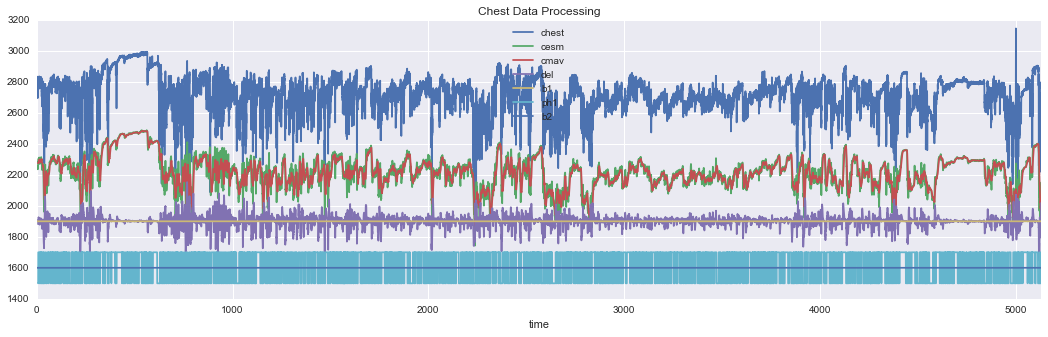

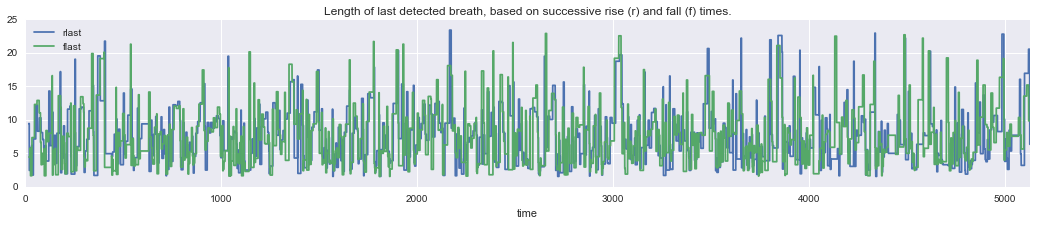

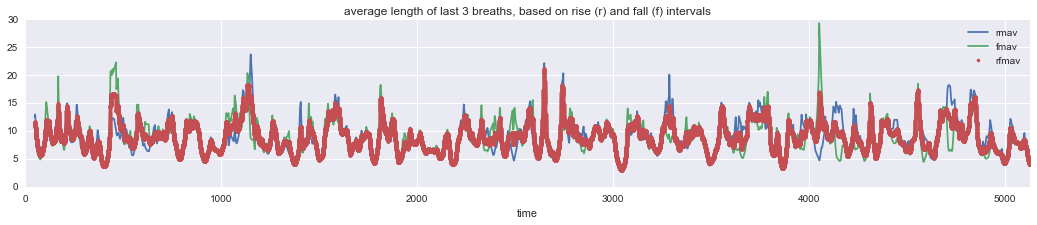

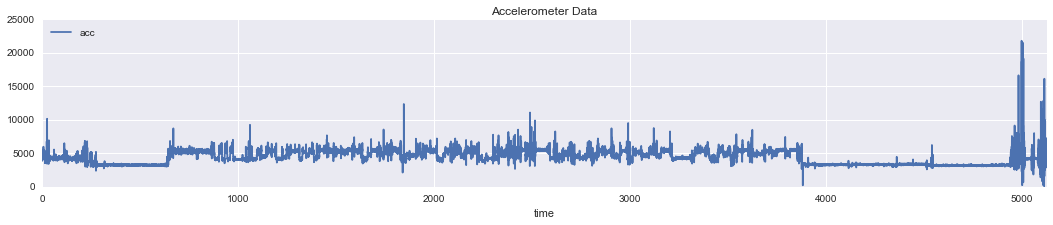

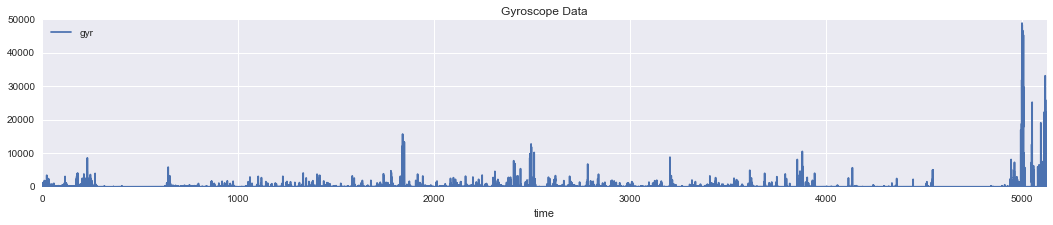

In [5]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 1600
g['b2'] = 1600
g.plot(x = 'time',y = ['chest','cesm','cmav','del','b1','ph1','b2'],figsize = (18,5),title = 'Chest Data Processing')
d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['-','-','.'], x = 'time',y = ['rmav','fmav','rfmav'], figsize = (18,3), title = 'average length of last 3 breaths, based on rise (r) and fall (f) intervals')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [6]:
print(d[::1000]) # every thousandth line of the processed dataset

         index  chest  belly  ax  ay  az  gx  gy  gz    time  ...   \
0            0   2773   2433  52 -10  33 -24   2  12     0.0  ...    
1000      1000   2644   2688  56  -5  36   7  10   1    50.0  ...    
2000      2000   2766   2742  60  -6  24   1  -3  -3   100.0  ...    
3000      3000   2814   2701  62  -1  18   4  -2  -2   150.0  ...    
4000      4000   2646   2818  59  -8  25   1  -2  -1   200.0  ...    
5000      5000   2706   2631  57   3  32  -3  -5   0   250.0  ...    
6000      6000   2848   2638  14  17 -53   1  -2  -2   300.0  ...    
7000      7000   2917   2719  14  19 -52   1  -2  -2   350.0  ...    
8000      8000   2919   2480  20  18 -51   1  -2  -2   400.0  ...    
9000      9000   2940   2500  19  18 -51   1  -2  -2   450.0  ...    
10000    10000   2972   2697  20  18 -50   1  -2  -2   500.0  ...    
11000    11000   2981   2675  20  19 -50   1  -2  -2   550.0  ...    
12000    12000   2915   2551  21  19 -50   1  -2  -2   600.0  ...    
13000    13000   244

In [7]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1,b2
0,0,2773,2433,52,-10,33,-24,2,12,0.00,...,[nan],NaN,NaN,NaN,NaN,NaN,3893,724,1900,1600
1,1,2782,2564,52,-10,33,-23,19,18,0.05,...,[nan],NaN,NaN,NaN,NaN,NaN,3893,1214,1900,1600
2,2,2792,2468,52,-10,33,-17,17,14,0.10,...,[nan],NaN,NaN,NaN,NaN,NaN,3893,774,1900,1600
3,3,2790,2581,52,-10,33,-14,20,13,0.15,...,[nan],NaN,NaN,NaN,NaN,NaN,3893,765,1900,1600
4,4,2795,2597,45,-9,51,-8,21,14,0.20,...,[nan],NaN,NaN,NaN,NaN,NaN,4707,701,1900,1600
5,5,2797,2598,45,-9,51,-4,22,13,0.25,...,[nan],NaN,NaN,NaN,NaN,NaN,4707,669,1900,1600
6,6,2800,2598,45,-9,51,2,16,12,0.30,...,[nan],NaN,NaN,NaN,NaN,NaN,4707,404,1900,1600
7,7,2803,2563,45,-9,51,5,13,9,0.35,...,[nan],NaN,NaN,NaN,NaN,NaN,4707,275,1900,1600
8,8,2801,2552,43,-9,54,8,9,11,0.40,...,[nan],NaN,NaN,NaN,NaN,NaN,4846,266,1900,1600
9,9,2805,2584,43,-9,54,12,4,10,0.45,...,[nan],NaN,NaN,NaN,NaN,NaN,4846,260,1900,1600
